In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data Cleaning & EDA

Data Dictionary:


| Column Name                     | Description                          | Data Type  |
|---------------------------------|--------------------------------------|------------|
| Gender                          | Gender of the individual, Male = 0, Female = 1 | Categorical |
| Age                             | Age of the individual                 | Continuous |
| Height                          | Height of the individual              | Continuous |
| Weight                          | Weight of the individual              | Continuous |
| family_history_with_overweight  | Family history of overweight, no = 0, yes = 1| Binary     |
| FAVC                            | Frequent consumption of high-calorie food, no = 0, yes = 1| Binary |
| FCVC                            | Frequency of vegetable consumption    | Continuous |
| NCP                             | Number of main meals per day          | Continuous |
| CAEC                            | Consumption of food between meals, no = 0, Sometimes = 1, Frequently = 2, Always = 3 | Categorical |
| SMOKE                           | Smoking habit of the individual, no = 0, yes = 1| Binary     |
| CH2O                            | Daily water consumption               | Continuous |
| SCC                             | Monitoring daily caloric intake, no = 0, yes = 1| Binary     |
| FAF                             | Physical activity frequency           | Continuous |
| TUE                             | Time spent on sedentary activities    | Continuous |
| CALC                            | Consumption of alcohol, no = 0, Sometimes = 1, Frequently = 2, Always = 3 | Categorical |
| MTRANS                          | Mode of transportation,Walking = 0, Bike = 1, Motorbike = 2, Public_Transportation = 3, Automobile = 4 | Categorical |
| NObeyesdad                      | Obesity level of the individual (PREDICTOR)      | Categorical |


Goal is to group individuals into categories based on health indicators. Nobeyesdad will be used as the ground truth labels and determine the accuracy of our modeling appraoches

In [47]:
df = pd.read_csv('obesity_data.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [48]:
# 17 columns to choose from. Dimensionality reduction will likely be needed before training a model
df.shape

(2111, 17)

In [49]:
# have some binary yes or no columns. Will need to convert those to 1 for yes and 0 for no or 1 for female and 0 for male. lets observe the unique values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [50]:
# observe unqiue values for each column and determine outlier values
def unique_values(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f'{col}: {df[col].unique()}')

unique_values(df)

Gender: ['Female' 'Male']
family_history_with_overweight: ['yes' 'no']
FAVC: ['no' 'yes']
CAEC: ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE: ['no' 'yes']
SCC: ['no' 'yes']
CALC: ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
NObeyesdad: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


The following will need to be considered for this dataset:
* Binary variables will need to be mapped to integer type with 0 representing NO and 1 representing YES
* Survey response questions with categorical data types will need to be mapped to inetger type. Likert scaling will be stored in data dictionary

In [51]:

# strip white space characters from the Gender column
df['Gender'] = df['Gender'].str.strip()
df['Gender'].value_counts()


Male      1068
Female    1043
Name: Gender, dtype: int64

In [52]:
# convert binary columns to 1 for yes and 0 for no
# include data quality checks in case data changes and invalid values are introduced

binary_cols = ['FAVC', 'SMOKE', 'SCC', 'family_history_with_overweight']
for col in binary_cols:
    df[col] = np.where(df[col] == 'yes', 1, np.where(df[col] == 'no', 0, 2))
    if df[col].any() == 2:
        print(f'Data Quality Error: {col} has a invalid value!')
    else:
        pass

df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,1,0,2.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,1,0,3.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,1,0,2.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,0,0,3.0,3.0,Sometimes,0,2.0,0,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,0,0,2.0,1.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [53]:
# convert likert columns
# no = 0, Sometimes = 1, Frequently = 2, Always = 3
# Walking = 0, Bike = 1, Motorbike = 2, Public_Transportation = 3, Automobile = 4 
# moved Gender here since it was runnign into issues above with the assignment of 2 to multiple variables
likert_cols = ['CAEC', 'CALC', 'MTRANS', 'Gender']
for col in likert_cols:
    if col == 'MTRANS':
        df[col] = np.where(df[col] == 'Walking', 0, np.where(df[col] == 'Bike', 1, np.where(df[col] == 'Motorbike', 2, \
            np.where(df[col] == 'Public_Transportation', 3, np.where(df[col] == 'Automobile', 4, 5)))))
        if df[col].any() == 5:
                print(f'Data Quality Error: {col} has a invalid value!')
    elif col == 'Gender':
        df[col] = np.where(df[col] == 'Male', 0, np.where(df[col] == 'Female', 1, 2))
        if df[col].any() == 2:
            print(f'Data Quality Error: {col} has a invalid value!')
        else:
            pass

    else:
        df[col] = np.where(df[col] == 'no', 0, np.where(df[col] == 'Sometimes', 1, np.where(df[col] == 'Frequently', 2, \
                np.where(df[col] == 'Always', 3, 4))))
        if df[col].any() == 4:
            print(f'Data Quality Error: {col} has a invalid value!')
        else:
            pass

df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,3,Normal_Weight
1,1,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,3,Normal_Weight
2,0,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,3,Normal_Weight
3,0,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,0,Overweight_Level_I
4,0,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,3,Overweight_Level_II


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   int64  
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   int64  
 5   FAVC                            2111 non-null   int64  
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   int64  
 9   SMOKE                           2111 non-null   int64  
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   int64  
 12  FAF                             21

In [55]:
# convert meters to feet for the height column for better understanding
df['Height'] = df['Height'] * 3.28084

In [56]:
# convert kilograms to lbs for the weight column for better understanding
df['Weight'] = df['Weight'] * 2.20462

In [57]:
df.describe()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,0.494079,24.312600,5.582931,190.889355,0.817622,0.883941,2.419043,2.685628,1.140692,0.020843,2.008011,0.045476,1.010298,0.657866,0.731407,3.125059
std,0.500083,6.345968,0.306118,57.741581,0.386247,0.320371,0.533927,0.778039,0.468543,0.142893,0.612953,0.208395,0.850592,0.608927,0.515498,0.676969
min,0.000000,14.000000,4.757218,85.980180,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.947192,5.347769,144.343841,1.000000,1.000000,2.000000,2.658738,1.000000,0.000000,1.584812,0.000000,0.124505,0.000000,0.000000,3.000000
50%,0.000000,22.777890,5.579065,182.983460,1.000000,1.000000,2.385502,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.625350,1.000000,3.000000
75%,1.000000,26.000000,5.802047,236.843830,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,2.477420,0.000000,1.666678,1.000000,1.000000,3.000000
max,1.000000,61.000000,6.496063,381.399260,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000


/var/folders/x8/mllw6tg55fs6mvzyfxq6kcwm0000gn/T/ipykernel_7466/3067848170.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


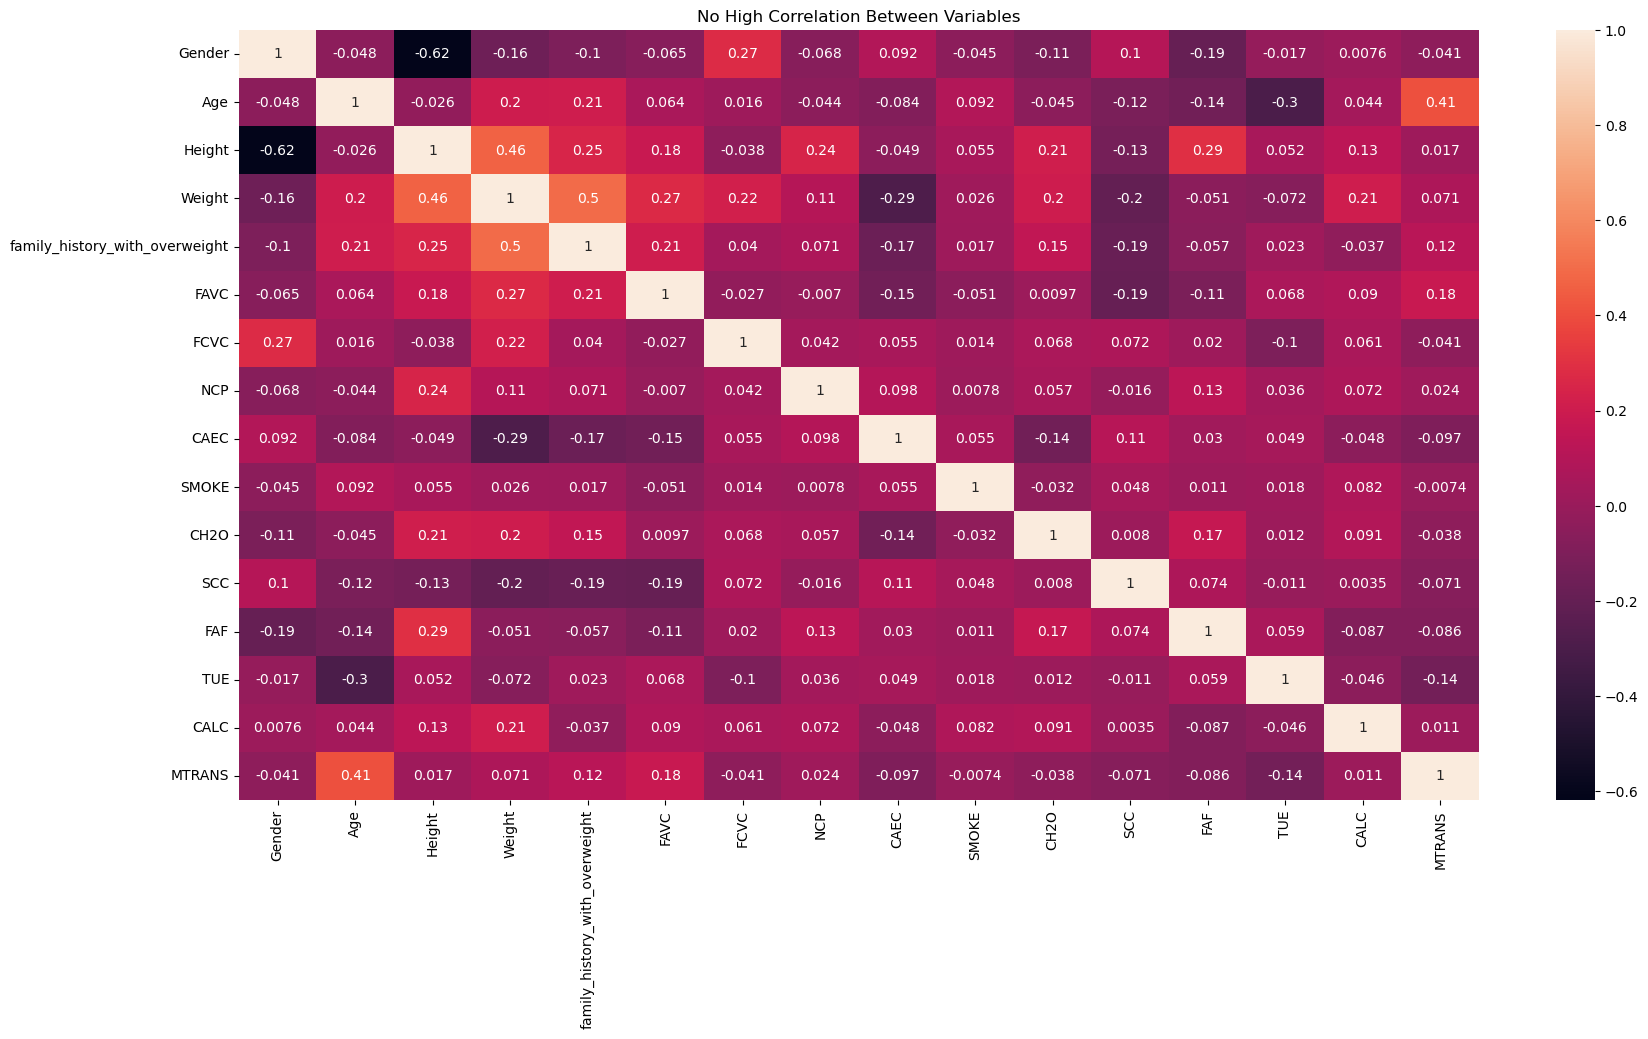

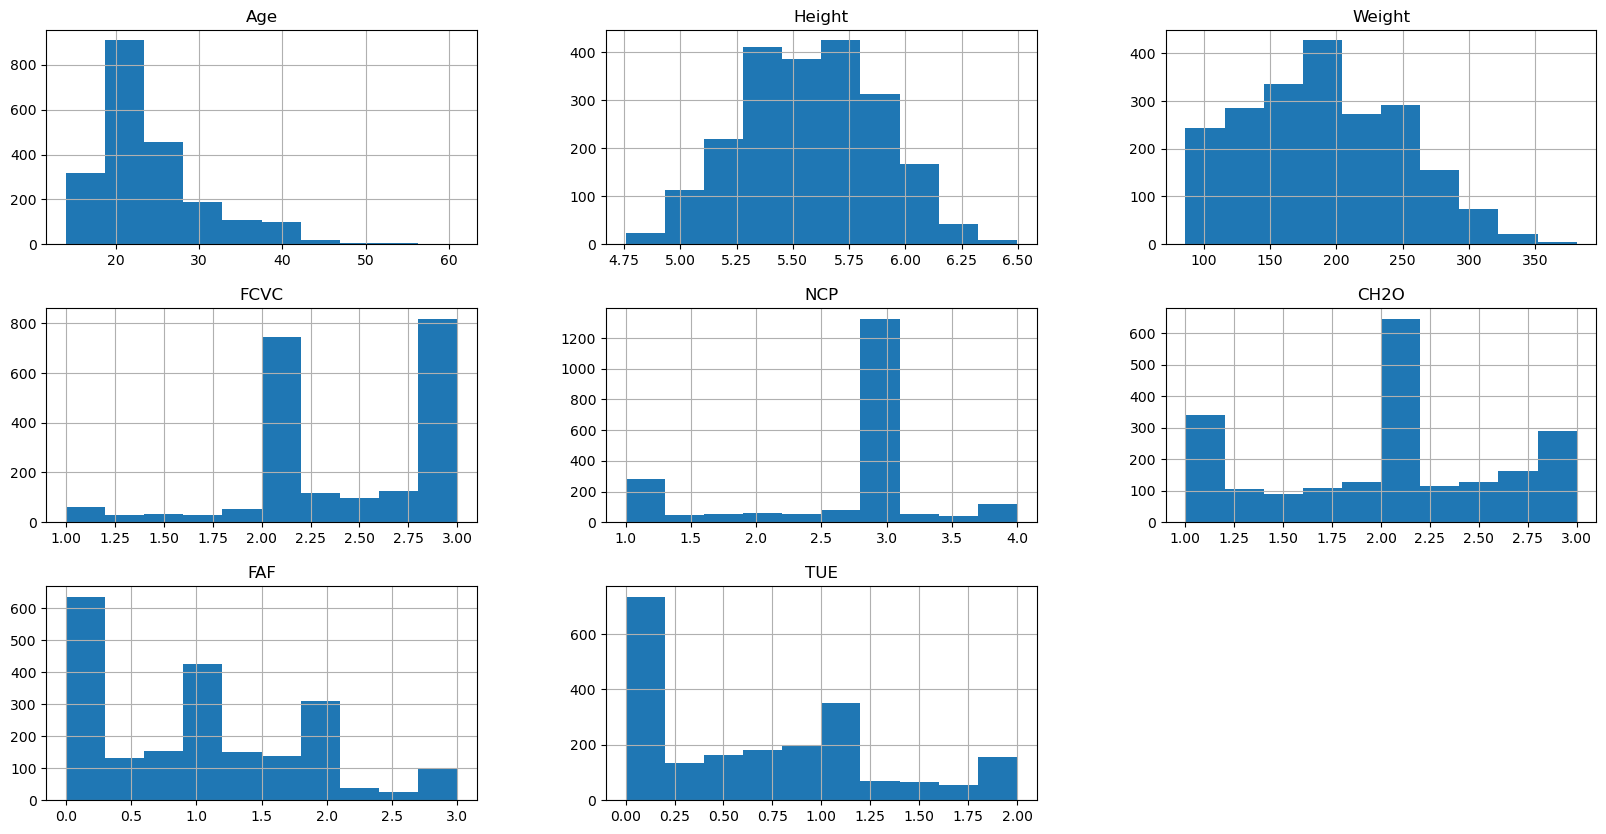

In [58]:
# create a correlation matrix to observe the relationships between the variables
correlation = df.corr()

plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True)
plt.title('No High Correlation Between Variables')
plt.show()



# create a histogram to observe the distribution of the data
df.select_dtypes(include=['float64']).hist(figsize=(20,10))
plt.title('Continuous Variable Distribution')
plt.show()



Findings for continuous variables:
* Age = population of mostly under 30 adults with minimum age of 14 and max age of 61
* Height = normally distributed with min of 4'7'' and max of 6'4''
* Weight = population of mostly under 200 lbs with minimum weight of 85 lbs and max of 381 lbs
* FCVC = most 